In [1]:
!pip install wandb
!pip install einops
!pip install matplotlib
!wandb login 5c9929a89dff059ff38878f32a6d8c70c49f3ea9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.1 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 14.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8792 sha256=b463fb97f322451be1f7fac7947f3ad65401d169ba6afded3b9f429421080b16
  Stored in directory: /root/.cache/pip/wheels/44/1b/54/249c94316d4e1030e2d0683fba1d8ea06197de866f5a4de738
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 431.3 kB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.7 MB/s eta 0:00:0000:01

In [2]:
import os, random, torch, wandb
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from einops import rearrange
from torch.optim import Adam
from torch import einsum
from math import sqrt
from time import time

### define GELU activation, LayerNorm module, GPT Layer, and GPT

In [3]:
# GELU(x) = x * ϕ(x) where ϕ is the CDF of the Gaussian distribution
class GELU(nn.Module):
  def forward(self, x):
    return x * 0.5 * (1 + torch.erf(x / sqrt(2)))

In [4]:
class LayerNorm(nn.Module):
  def __init__(self, d, eps=1e-5):
    super().__init__()
    self.d, self.eps = d, eps
    self.w = nn.Parameter(torch.tensor(1.))
    self.b = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    for i in range(len(x.shape) - 1, -1, -1):
      if x.shape[i] == self.d:
        d = i
        break
    mu = x.mean(d).unsqueeze(d)  # E[x]
    mu_ = (x * x).mean(d).unsqueeze(d)  # E[x^2]
    sigma = torch.sqrt(mu_ - mu * mu + self.eps)
    return self.w * (x - mu) / sigma + self.b

In [5]:
class Layer(nn.Module):
  def __init__(self, d, nh):
    super().__init__()
    assert d % nh == 0, 'number of heads should divide embedding dim'
    self.d, self.nh, self.h = d, nh, d // nh
    self.wx, self.wo = nn.Linear(d, 3 * d), nn.Linear(d, d)
    self.ln1, self.ln2 = LayerNorm(d), LayerNorm(d)
    self.ffn = nn.Sequential(
      nn.Linear(d, 4 * d), GELU(), nn.Linear(4 * d, d)
    )

    def fn(m):
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.02)
        nn.init.zeros_(m.bias)

    self.apply(fn)

  def forward(self, xm):
    x, m = xm
    qkv = rearrange(self.wx(self.ln1(x)), 'b l D -> b D l')
    q, k, v = rearrange(qkv, 'b (N h) l -> b N h l', h=self.h).split(self.nh, 1)
    A = F.softmax((einsum('bhri, bhrj -> bhij', q, k) + m) / sqrt(self.d), -1)
    H = einsum('bhic, bhjc -> bhij', v, A)
    MHA = rearrange(rearrange(H, 'b nh h l -> b (nh h) l'), 'b d l -> b l d')
    x = x + self.wo(MHA)
    return x + self.ffn(self.ln2(x)), m

In [6]:
class GPT(nn.Module):
  def __init__(self, d, nh, nl, l, v):
    super().__init__()
    self.l = l
    self.emb = nn.Embedding(v, d)  # token embeddings 
    nn.init.normal_(self.emb.weight, 0, 0.02)
    self.pos = nn.Parameter(torch.randn(l, d) * 0.02)  # learned position embeddings
    m = torch.tril(torch.ones(l, l)) - 1
    m[m == -1] = float('-inf')
    self.m = nn.Parameter(m, requires_grad=False)  # mask
    self.layers = nn.Sequential(*[Layer(d, nh) for _ in range(nl)])  # layers 
    self.out = nn.Linear(d, v, bias=False)  # embedding to logits projection 
    nn.init.normal_(self.out.weight, 0, 0.02)
    self.size = sum(p.numel() for p in self.parameters() if p.requires_grad)

  def forward(self, t):
    l = t.shape[-1]
    assert l <= self.l, f'input sequence length should be <= {self.l}'
    if len(t.shape) == 1:
      t = t.unsqueeze(0)  # (l,) to (1, l)
    xm = (self.emb(t) + self.pos[:l], self.m[:l, :l])
    return self.out(self.layers(xm)[0]).squeeze()

  def loss(self, it, ot):
    return F.cross_entropy(
      rearrange(self(it), 'b l v -> (b l) v'), rearrange(ot, 'b l -> (b l)')
    )

### load dataset, create encoder and decoder

In [7]:
text = ''
for book in os.listdir('HP'):
  text += open('HP/' + book).read()
print(f'size of the text: {len(text)} characters')

size of the text: 6765174 characters


In [8]:
vocab = set(text)
print(f'size of the vocabulary: {len(vocab)} characters')
print(vocab)

size of the vocabulary: 92 characters
{'1', '—', '%', 'W', '•', 'E', 'I', 'L', 'p', 'a', '!', 'n', 'b', 'z', ' ', ':', 'x', 'o', '3', 'G', 'Z', 'j', ']', 'y', '?', ';', ',', 'D', '"', '”', '■', 'H', '4', '2', 'N', 'P', '\\', 'f', 'B', 'F', 'w', 'M', 'R', '-', 'U', 'A', 'h', '5', '(', '>', '’', 'u', ')', 'g', 'C', 'r', 'X', '/', 'm', 'O', 's', 'd', '□', '7', 'k', '.', '9', '8', "'", 'i', '\n', 'T', '6', 'e', 'Y', '‘', 'Q', 'K', 'c', '|', '0', '*', '“', 'J', 't', 'S', '~', 'v', 'V', 'l', 'q', '&'}


In [9]:
stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}
encode = lambda string: [stoi[x] for x in string]
decode = lambda ids: ''.join([itos[x] for x in ids])

# test
print(decode(encode('Hello, World!')))
print(encode(decode([1, 2, 3, 4, 5])))

Hello, World!
[1, 2, 3, 4, 5]


In [10]:
train_ids = encode(text)
# character-level encoding => this equality should hold
assert len(train_ids) == len(text)
# convert to tensor
train_ids = torch.tensor(train_ids)

In [11]:
def get_batch(batch_size, l, device):
  ids = random.choices(range(len(train_ids) - l - 1), k=batch_size) 
  batch = torch.stack([train_ids[i:i + l + 1] for i in ids])
  return batch[:, :-1].to(device), batch[:, 1:].to(device)

In [12]:
d = 12 * 30
nh = 12
nl = 8
l = 256
v = len(vocab)
batch_size = 64
steps = 15000
interval = 100
lr = 2e-4

if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

In [13]:
model = GPT(d, nh, nl, l, v).to(device)
print(f'size of the model: {model.size} parameters')
optimizer = Adam(model.parameters(), lr=lr)

size of the model: 12625952 parameters


### train loop

In [14]:
wandb.init(project='Harry Potter GPT')

losses = []
scaler = GradScaler()
s = time()
for i in range(1, steps + 1):
  # fp16 training
  with autocast():
    loss = model.loss(*get_batch(batch_size, l, device))
  # logging
  losses.append(loss.item())
  wandb.log({'loss': losses[-1]})
  if i % interval == 0:
    avg_loss = sum(losses[-interval:]) / interval 
    print(f'loss: {avg_loss}\tstep: {i}\ttime: {time() - s}s')
    s = time()
  # training step
  scaler.scale(loss).backward()
  scaler.step(optimizer)
  scaler.update()
  optimizer.zero_grad()

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akbirthko. Use `wandb login --relogin` to force relogin


loss: 2.6873867082595826	step: 100	time: 10.782800436019897s
loss: 2.396345093250275	step: 200	time: 9.91555118560791s
loss: 2.287114098072052	step: 300	time: 9.88750171661377s
loss: 2.07937398314476	step: 400	time: 9.892699003219604s
loss: 1.856336110830307	step: 500	time: 9.942489624023438s
loss: 1.6782416546344756	step: 600	time: 9.909074783325195s
loss: 1.5595942151546478	step: 700	time: 9.910406351089478s
loss: 1.472735446691513	step: 800	time: 9.90741777420044s
loss: 1.4003612315654754	step: 900	time: 9.893937349319458s
loss: 1.3459407794475555	step: 1000	time: 9.895828008651733s
loss: 1.296998964548111	step: 1100	time: 9.897517681121826s
loss: 1.2614178800582885	step: 1200	time: 9.889032125473022s
loss: 1.2295482087135314	step: 1300	time: 9.884357929229736s
loss: 1.202757350206375	step: 1400	time: 9.896944284439087s
loss: 1.1839455544948578	step: 1500	time: 9.892374753952026s
loss: 1.1646054148674012	step: 1600	time: 9.886283159255981s
loss: 1.1450844883918763	step: 1700	time: 9

loss,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
loss,0.55142


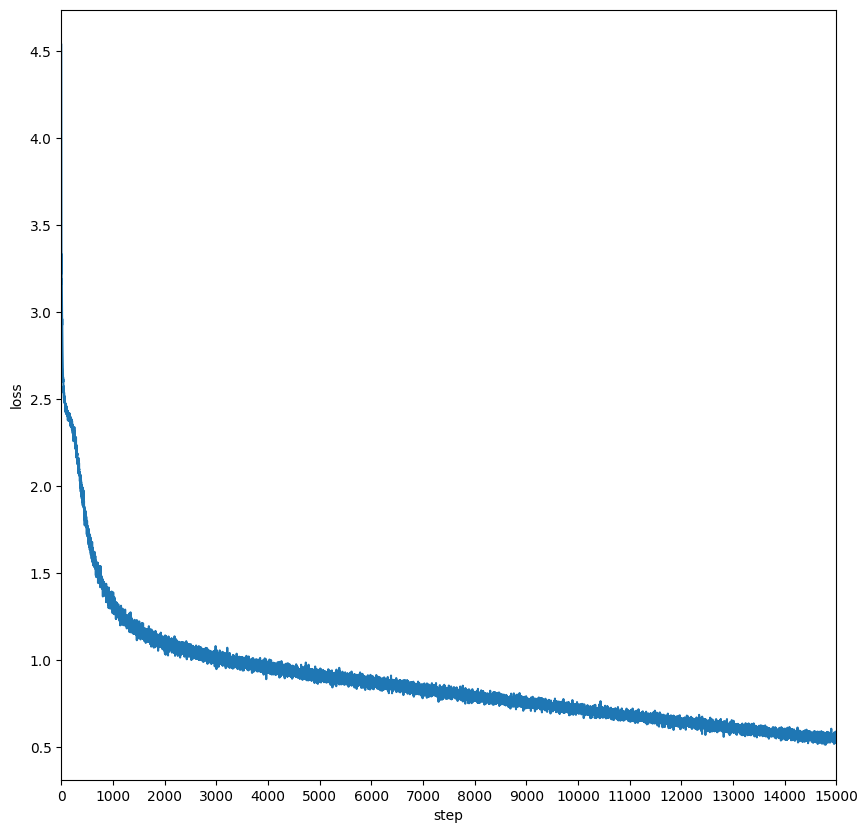

In [15]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('step')
plt.ylabel('loss')
plt.xlim(0, steps)
plt.xticks(list(range(0, steps + 1000, 1000)))
plt.plot(list(range(steps)), losses)

### test the model

In [16]:
def generate(model, text, n, temp=0.9, device='cpu'):
  assert len(text) > 0
  print(text, end='')
  it = torch.tensor(encode(text)).to(device)  # input tokens
  with torch.no_grad():
    for _ in range(n):
      p = F.softmax(model(it[-model.l:]) / temp, -1)[-1]  # prob distribution
      t = torch.multinomial(p, 1)  # next token
      it = torch.cat((it, t), -1)  # concatenate with prev tokens
      text += decode([t.item()])  # concatenate with prompt
      print(text[-1], end='')
    return text, it  # return completed text and tokens

In [17]:
_ = generate(model, 'Harry and Hagrid entered Diagon Alley', 500, device=device)

Harry and Hagrid entered Diagon Alley. 

“Yes, yeh’ll know what I’m going to — er — yeh hoped 
think yer birthday first.” 

Hagrid reached out a ripple air and a trunk, pinced a 
square sensit of a road ideocat shudder. There was a 
round and outline dark, and as Harry saw Hermione’s 
muttering in the silence beside him. Squinting at 
Harry, then placed his scarf felt again. 

There was nothing here to be flying to it, in the same 
shadow of a black rustle of A. 

He threw his whole body through the concealed 
akes and returned wit

In [18]:
_ = generate(model, 'Voldemort cast his wand aside and', 500, device=device)

Voldemort cast his wand aside and the corridor 
shield his last week, then the elf had never left the 
first time he were there — 

The snake was whipping his face and his head 
curled into fists. It seemed to have joining in 
darkness. Riddle’s face was still squinting at his 
fingers, which wenting still, he tottered to fix a little 
ahead of him. Harry pushed his head over his head, 
perched perfectly, but walked up to seconds, moving 
in street, then leapt up the passageway. 



Page | 264Harry Potter and the Order of the P

In [20]:
_ = generate(
  model,
  'Dumbledore sent a blast of fire from his wand direct at Voldemort',
  4000,
  temp=0.8,
  device=device
)

Dumbledore sent a blast of fire from his wand direct at Voldemort’s 
nostrils. 

“You see, in fact, I do some of the potion will be going 
in these days, Dobby thought the arts would not kill 
him as a great and better than it has been known as 
Parselmouth. Harry Potter, sir, very close to the 
boy — his reply, scabbed elves, down the man — 
just like the parcel or rats and the sound of the 
whistle creaking of the man held... 

The spider had importantly been fanged except for 
every drop of the hollidays, the top of one, a bit labeled 
statump on the wall to the shore. 

THIP WITH THIS ALE WITCHANDED WITH AND 
DIET. OF YOUR ABNORMALITY SURRIENCLY 
SECWOND. 1SWOLLS ARE LAUGHION SO ENTRANT SKY- 
HoRe-Quighler — gave him the Quaffle, Quidditch 
the Quibbler. 

The silver doe opened his bedroom seemed to be 
packed so clear that it headed easily as though it were a 
bit deepened, not so often in the darkness slow drifted 
his arms around his knees and staring in for some 
distinctions. 

### save the model checkpoint

In [21]:
torch.save(model.state_dict(), 'GPT-HP.pt')